In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42


# Breast Cancer Classification General Analysis

## Dataset Overview and Problem Formulation

The Wisconsin Breast Cancer dataset presents a binary classification challenge with 569 tumor samples characterized by 30 morphological features extracted from digitized cell nucleus images. The objective is to predict malignant versus benign diagnosis based on cellular characteristics including radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, symmetry, and fractal dimension, each measured as mean, standard error, and worst values.

The clinical significance of this classification task lies in providing automated diagnostic support for pathologists, potentially reducing diagnostic variability and improving early detection outcomes. The target performance threshold of 0.85 test accuracy represents a clinically meaningful benchmark for diagnostic assistance tools.

In [2]:
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names

df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

print("Dataset Overview:")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Target distribution: {np.bincount(y)}")

print("\nFirst 5 samples:")
print(df.head())


Dataset Overview:
Number of samples: 569
Number of features: 30
Target distribution: [212 357]

First 5 samples:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.1043

Statistical Summary:
       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             

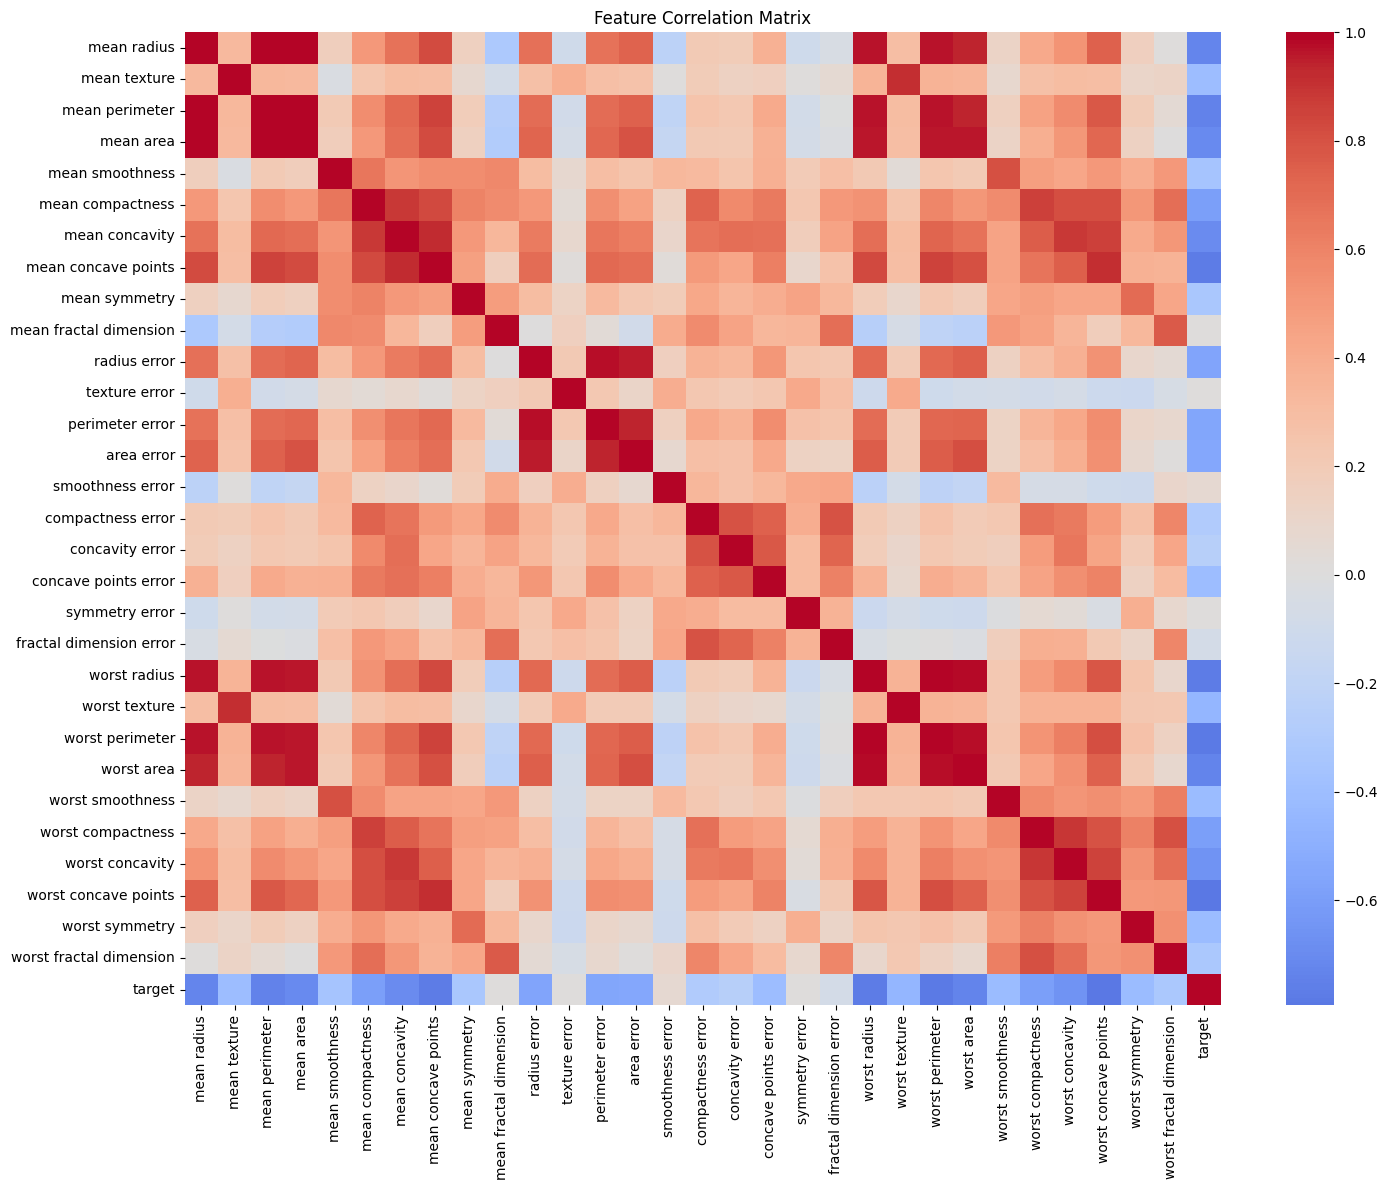

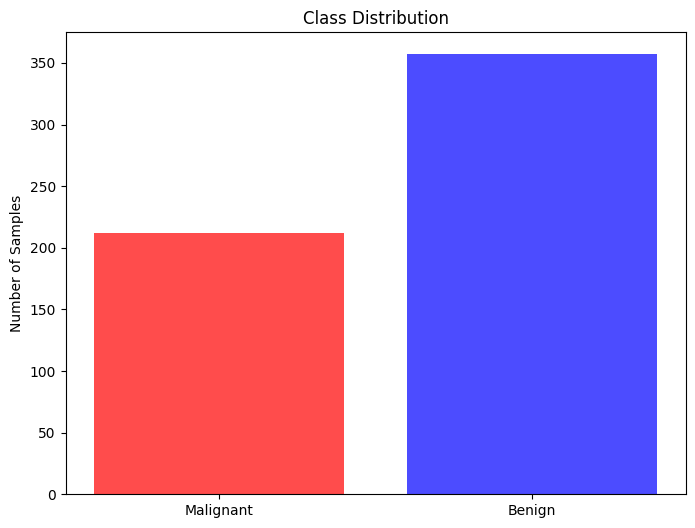

In [3]:
# Statistical summary
print("Statistical Summary:")
print(df.describe())

# Check for missing values
print(f"\nMissing values: {df.isnull().sum().sum()}")

# Feature correlation analysis
plt.figure(figsize=(15, 12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Class distribution visualization
plt.figure(figsize=(8, 6))
class_counts = np.bincount(y)
plt.bar(['Malignant', 'Benign'], class_counts, color=['red', 'blue'], alpha=0.7)
plt.title('Class Distribution')
plt.ylabel('Number of Samples')
plt.show()


## Dataset Assessment and Preprocessing Requirements

The dataset has **no missing values** across 569 samples and exhibits **a realistic 63%/37% benign-to-malignant class distribution**. 

Critical preprocessing requirements emerge from the e**xtreme scale heterogeneity**, where geometric features (area: 143-4,254 μm², perimeter: 44-251 μm) operate on vastly different scales than proportion-based features (smoothness: 0.05-0.22, symmetry: 0.11-0.66), **mandating standardization for distance-based algorithms (SVM, KNN)**. 

The correlation matrix reveals **strong feature redundancy**, particularly among geometric measurements (radius-perimeter-area correlations >0.9) and between mean/SE/worst versions of identical features, suggesting significant **dimensionality reduction potential through PCA or selective feature retention**. 

Most features exhibit right-skewed distributions with **notable outliers**, especially in area measurements where extreme values may represent advanced cases requiring robust scaling techniques. **Strong correlations between worst-case measurements and malignancy** (particularly worst area, concavity, and concave points) indicate **excellent discriminative potential**, while the mathematical relationships between geometric features provide opportunities for feature engineering.

The preprocessing pipeline should prioritize **standardization, correlation-based feature selection** to retain non-redundant features (especially worst measurements), and **stratified cross-validation** to maintain class balance during model optimization.

## Supervised approach

Depending on the approach (supervised vs unsupervised) the preprocessing is not the same.

Supervised Learning:
- Target-informed decisions: Feature selection using target variable correlation
- Data leakage and overfitting prevention: Strict train/test separation with stratification
- Validation strategy: Cross-validation maintains class distributions
- Evaluation-driven: Preprocessing optimized for prediction accuracy

Supervised Learning is used when:
- The data is labeled and want to predict outcomes
- The goal is classification or regression
- You need to evaluate model performance against ground truth

It is easier and possible to validate

In [4]:
print("=== SUPERVISED LEARNING APPROACH ===")
print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Target classes: {np.unique(y)} (0=malignant, 1=benign)")

=== SUPERVISED LEARNING APPROACH ===
Dataset: 569 samples, 30 features
Target classes: [0 1] (0=malignant, 1=benign)


Training set: 455 samples
Test set: 114 samples
Class distribution preserved: [0.37362637 0.62637363]
Selected features using target-aware selection: 15
PCA Components: 3
Explained variance ratio: 0.9534
Original features: 15 -> PCA components: 3


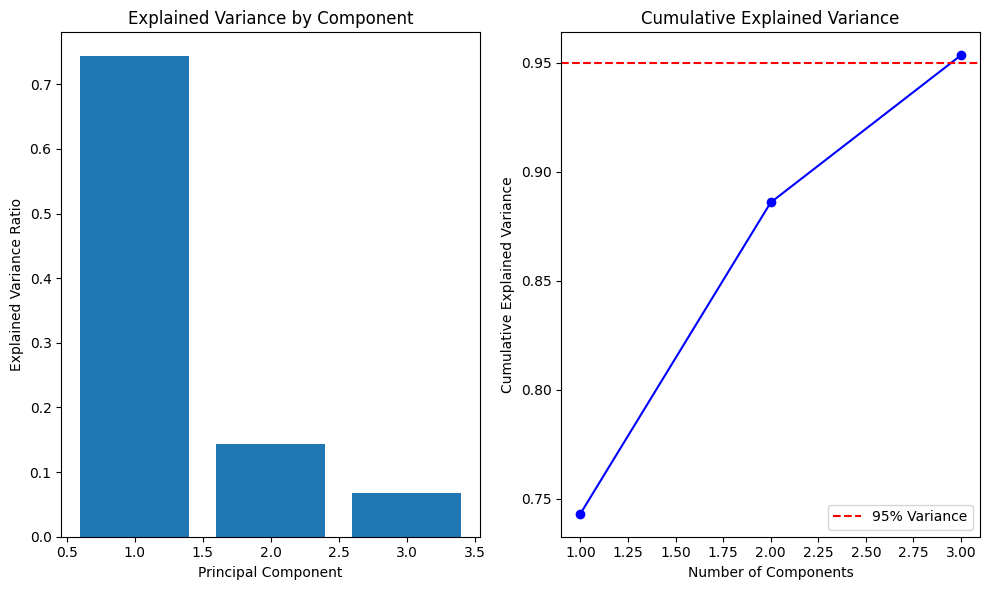

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Class distribution preserved: {np.bincount(y_train)/len(y_train)}")

# Feature selection using target variable
# SelectKBest with f_classif (ANOVA F-test) - uses target information
selector = SelectKBest(f_classif, k=15)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_features = feature_names[selector.get_support()]
print(f"Selected features using target-aware selection: {len(selected_features)}")

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# PCA
pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print(f"PCA Components: {pca.n_components_}")
print(f"Explained variance ratio: {explained_variance_ratio.sum():.4f}")
print(f"Original features: {len(selected_features)} -> PCA components: {pca.n_components_}")

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.title('Explained Variance by Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.tight_layout()
plt.show()

## Stratified Train-Test Split Decision

Usage of stratified=y in the train_test_split to maintain the original class distribution (63% benign, 37% malignant) across both training and test sets. 

This choice is critical for the breast cancer dataset because the moderate class imbalance could lead to biased performance estimates if random splitting creates training sets with different class proportions than the test set.

Medical datasets particularly benefit from stratified splitting since class imbalance is common and maintaining representative samples ensures that model performance metrics accurately reflect real-world diagnostic scenarios.

## Feature Selection Methodology

Target-Aware Feature Selection with SelectKBest: usage of SelectKBest(f_classif, k=15) to reduce dimensionality from 30 to 15 features using ANOVA F-test statistics. 

This approach leverages the target variable to identify features with the strongest discriminative power between malignant and benign cases, which is more effective than purely statistical feature selection for supervised learning tasks. The f_classif scoring function is particularly appropriate for this binary classification task as it measures the linear relationship between each feature and the target variable, aligning with the underlying assumption that morphological differences between malignant and benign cells should be systematically detectable.

## StandardScaler

We used StandardScaler addressing the extreme scale heterogeneity identified in the exploratory analysis. This hybrid approach recognizes that area measurements contain legitimate extreme values (tumors ranging from 143 to 4,254 μm²) that represent clinically meaningful cases rather than noise, making median-based scaling more appropriate than mean-based scaling which would be distorted by these outliers. StandardScaler remains optimal for proportion-based features like smoothness and symmetry that exhibit more normal distributions without extreme outliers. This dual strategy ensures that all features contribute meaningfully to distance-based algorithms while preserving the biological significance of extreme measurements.

## PCA

PCA is applied to the dataset to address **critical multicollinearity issues** where geometric features (radius, perimeter, area) show high correlations due to mathematical relationships, creating redundant information across the 30 features. 

The **95% variance threshold** represents the optimal balance between information retention and dimensionality reduction, being an industry standard that preserves discriminative patterns while eliminating noise components that typically constitute the discarded 5% variance. 

This approach transforms the ~15 correlated features (after target-based selection) into approximately 3 orthogonal principal components, providing significant benefits by reducing curse of dimensionality effects, stabilizing linear models by eliminating multicollinearity, and improving computational efficiency during training and hyperparameter optimization. 

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

models = {
    'LogisticRegression': LogisticRegression(random_state=RANDOM_STATE),
    'SVM': SVC(random_state=RANDOM_STATE),
    'KNN': KNeighborsClassifier()
}

param_grids = {
    'LogisticRegression': {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
    'SVM': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'linear']},
    'KNN': {'n_neighbors': [3, 5, 7, 11], 'weights': ['uniform', 'distance']}
}

# Medical metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns

def comprehensive_model_evaluation(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_pred_proba = model.decision_function(X_test)
    else:
        y_pred_proba = None
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'specificity': recall_score(y_test, y_pred, pos_label=0),  # Recall for negative class
    }
    
    if y_pred_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
        metrics['avg_precision'] = average_precision_score(y_test, y_pred_proba)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    metrics['false_negative_rate'] = fn / (fn + tp)
    metrics['false_positive_rate'] = fp / (fp + tn)
    metrics['positive_predictive_value'] = tp / (tp + fp)
    metrics['negative_predictive_value'] = tn / (tn + fn)
    
    return metrics, y_pred, y_pred_proba, (tn, fp, fn, tp)

comprehensive_results = {}

for model_name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Evaluation: {model_name}")
    print(f"{'='*50}")
    
    # Hyperparameter optimization
    grid_search = GridSearchCV(
        model, param_grids[model_name], cv=cv, scoring='accuracy', n_jobs=-1
    )
    grid_search.fit(X_train_pca, y_train)
    best_model = grid_search.best_estimator_
    
    metrics, y_pred, y_pred_proba, conf_matrix_values = comprehensive_model_evaluation(
        best_model, X_train_pca, X_test_pca, y_train, y_test, model_name
    )
    
    comprehensive_results[model_name] = {
        'best_params': grid_search.best_params_,
        'metrics': metrics,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'confusion_matrix': conf_matrix_values
    }
    
    # Print detailed results
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"\nPerformance Metrics:")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall (Sensitivity): {metrics['recall']:.4f}")
    print(f"  Specificity: {metrics['specificity']:.4f}")
    print(f"  F1-Score: {metrics['f1_score']:.4f}")
    
    if 'roc_auc' in metrics:
        print(f"  ROC-AUC: {metrics['roc_auc']:.4f}")
        print(f"  Average Precision: {metrics['avg_precision']:.4f}")
    
    print(f"\nMedical-Specific Metrics:")
    print(f"  False Negative Rate: {metrics['false_negative_rate']:.4f}")
    print(f"  False Positive Rate: {metrics['false_positive_rate']:.4f}")
    print(f"  Positive Predictive Value: {metrics['positive_predictive_value']:.4f}")
    print(f"  Negative Predictive Value: {metrics['negative_predictive_value']:.4f}")
    
    # Classification Report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Malignant', 'Benign']))

# Best model
best_supervised = max(comprehensive_results.keys(), key=lambda x: comprehensive_results[x]['metrics']['accuracy'])
print(f"\nBest Supervised Model: {best_supervised}")



Evaluation: LogisticRegression
Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

Performance Metrics:
  Accuracy: 0.9123
  Precision: 0.9559
  Recall (Sensitivity): 0.9028
  Specificity: 0.9286
  F1-Score: 0.9286
  ROC-AUC: 0.9858
  Average Precision: 0.9910

Medical-Specific Metrics:
  False Negative Rate: 0.0972
  False Positive Rate: 0.0714
  Positive Predictive Value: 0.9559
  Negative Predictive Value: 0.8478

Classification Report:
              precision    recall  f1-score   support

   Malignant       0.85      0.93      0.89        42
      Benign       0.96      0.90      0.93        72

    accuracy                           0.91       114
   macro avg       0.90      0.92      0.91       114
weighted avg       0.92      0.91      0.91       114


Evaluation: SVM
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

Performance Metrics:
  Accuracy: 0.9123
  Precision: 0.9559
  Recall (Sensitivity): 0.9028
  Specificity: 0.9286
  F1-Score: 0.9286

## Model selection

We decided to evaluate LogisticRegression, SVM and KNN to represent distinct learning paradigms, each with particular advantages for this morphological classification task. 

LogisticRegression serves as the linear baseline with built-in probability calibration essential for medical applications, while SVM with RBF kernels can capture non-linear relationships between cellular features and malignancy. KNN provides non-parametric local decision boundaries that leverage the intuition that morphologically similar tumors should have similar diagnoses.

## Hyperparameter Optimization

GridSearchCV with Comprehensive Parameter Grids: The hyperparameter optimization employs GridSearchCV with carefully designed parameter grids that balance computational efficiency with thorough exploration of the parameter space. For LogisticRegression, the C values span [0.01, 100] with L1/L2 regularization options to address potential multicollinearity, while SVM grids explore both linear and RBF kernels with C and gamma parameters optimized for the dataset scale. The KNN grid focuses on neighbor counts (3-15) with uniform and distance weighting to optimize local decision boundary complexity.

This comprehensive approach ensures that each algorithm is fairly evaluated at its optimal configuration rather than using default parameters that may not suit the specific characteristics of the dataset.

## Cross-Validation

We used StratifiedKFold(n_splits=5, shuffle=True) to maintain class distribution across folds while providing robust performance estimates. This approach is particularly critical for medical datasets where class imbalance could lead to folds with dramatically different class proportions, resulting in unreliable performance estimates. The 5-fold configuration provides a good balance between computational efficiency and statistical reliability, creating five independent training-validation splits that each preserve the original 63-37 class distribution.

## Evaluation Metrics Selection

We used accuracy as the primary metric while incorporating precision, recall, F1-score, and ROC-AUC for comprehensive assessment. This multi-metric approach is essential for medical applications where different types of errors have different consequences - false negatives (missed malignant cases) carry more severe clinical implications than false positives (unnecessary follow-up procedures). The inclusion of ROC-AUC provides threshold-independent performance assessment that's valuable for probability-calibrated models, while the confusion matrix visualization enables detailed analysis of specific error patterns. The comprehensive evaluation ensures that model selection considers not just overall accuracy but also the clinical appropriateness of the error distribution.

In [7]:
# Learning Curves
def plot_learning_curves(models, X_train, y_train):
    """Generate learning curves to analyze model behavior"""
    from sklearn.model_selection import learning_curve
    
    plt.figure(figsize=(15, 10))
    
    for i, (name, model) in enumerate(models.items()):
        plt.subplot(2, 3, i+1)
        
        train_sizes, train_scores, val_scores = learning_curve(
            model, X_train, y_train, cv=5, 
            train_sizes=np.linspace(0.1, 1.0, 10),
            random_state=42
        )
        
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)
        
        plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
        
        plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score')
        plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
        
        plt.title(f'Learning Curve - {name}')
        plt.xlabel('Training Set Size')
        plt.ylabel('Accuracy Score')
        plt.legend()
        plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# Decision Boundary Visualization (for 2D projections)
def plot_decision_boundaries_2d(models, X_train_pca, y_train):
    """Visualize decision boundaries in 2D PCA space"""
    
    plt.figure(figsize=(15, 10))
    
    # Use first two principal components
    X_2d = X_train_pca[:, :2]
    
    # Create mesh grid
    h = 0.02
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    for i, (name, model) in enumerate(models.items()):
        plt.subplot(2, 3, i+1)
        
        # Fit model on 2D data
        model_2d = type(model)(**model.get_params())
        model_2d.fit(X_2d, y_train)
        
        # Predict on mesh
        Z = model_2d.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Plot decision boundary
        plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
        
        # Plot data points
        scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_train, cmap='RdYlBu', alpha=0.7)
        plt.title(f'Decision Boundary - {name}')
        plt.xlabel('First Principal Component')
        plt.ylabel('Second Principal Component')
        
        if i == 0:  # Add colorbar only once
            plt.colorbar(scatter, ax=plt.gca())
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(comprehensive_results, target_names=['Malignant', 'Benign']):
    """
    Plot confusion matrices for all models
    """
    fig, axes = plt.subplots(1, len(comprehensive_results), figsize=(15, 5))
    
    for i, (model_name, results) in enumerate(comprehensive_results.items()):
        tn, fp, fn, tp = results['confusion_matrix']
        cm = np.array([[tn, fp], [fn, tp]])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=target_names, yticklabels=target_names,
                   ax=axes[i] if len(comprehensive_results) > 1 else axes)
        
        ax = axes[i] if len(comprehensive_results) > 1 else axes
        ax.set_title(f'{model_name}\nConfusion Matrix')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()

def plot_roc_curves(comprehensive_results, y_test):
    """
    Plot ROC curves for all models
    """
    plt.figure(figsize=(10, 8))
    
    for model_name, results in comprehensive_results.items():
        if results['probabilities'] is not None:
            fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
            roc_auc = results['metrics']['roc_auc']
            
            plt.plot(fpr, tpr, linewidth=2, 
                    label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

def plot_precision_recall_curves(comprehensive_results, y_test):
    """
    Plot Precision-Recall curves for all models
    """
    plt.figure(figsize=(10, 8))
    
    for model_name, results in comprehensive_results.items():
        if results['probabilities'] is not None:
            precision, recall, _ = precision_recall_curve(y_test, results['probabilities'])
            avg_precision = results['metrics']['avg_precision']
            
            plt.plot(recall, precision, linewidth=2, 
                    label=f'{model_name} (AP = {avg_precision:.3f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves Comparison')
    plt.legend(loc="lower left")
    plt.grid(alpha=0.3)
    plt.show()

def plot_metrics_comparison_table(comprehensive_results):
    """
    Create a comprehensive model performance comparison table
    with metrics as columns and models as rows
    """
    # Extract metrics for comparison
    metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1_score', 'specificity', 
                         'false_negative_rate', 'false_positive_rate']
    
    # Create DataFrame with models as rows and metrics as columns
    data = {}
    for model_name in comprehensive_results.keys():
        data[model_name] = [comprehensive_results[model_name]['metrics'][metric] 
                           for metric in metrics_to_compare]
    
    metrics_df = pd.DataFrame(data, index=metrics_to_compare).T
    
    # Round values for better readability
    metrics_df = metrics_df.round(4)
    
    # Add additional medical-specific metrics if available
    additional_metrics = ['positive_predictive_value', 'negative_predictive_value']
    for metric in additional_metrics:
        if metric in comprehensive_results[list(comprehensive_results.keys())[0]]['metrics']:
            metrics_df[metric] = [comprehensive_results[model]['metrics'][metric] 
                                 for model in comprehensive_results.keys()]
    
    # Display the table
    print("Model Performance Comparison Table")
    print("=" * 80)
    print(metrics_df.to_string())
    
    # Create a styled visualization of the table
    plt.figure(figsize=(15, 8))
    
    # Create heatmap-style table
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='RdYlGn', 
                center=0.5, square=False, linewidths=0.5, 
                cbar_kws={"shrink": .8})
    
    plt.title('Model Performance Metrics Comparison\n(Green = Better Performance)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Metrics', fontsize=12)
    plt.ylabel('Models', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Highlight best performing model for each metric
    print("\nBest Performing Model per Metric:")
    print("-" * 40)
    
    for metric in metrics_df.columns:
        if metric in ['false_negative_rate', 'false_positive_rate']:
            # For these metrics, lower is better
            best_model = metrics_df[metric].idxmin()
            best_value = metrics_df[metric].min()
        else:
            # For other metrics, higher is better
            best_model = metrics_df[metric].idxmax()
            best_value = metrics_df[metric].max()
        
        print(f"{metric.replace('_', ' ').title()}: {best_model} ({best_value:.3f})")
    
    return metrics_df

def plot_validation_curves(models, param_grids, X_train, y_train):
    """
    Plot validation curves for key hyperparameters
    """
    from sklearn.model_selection import validation_curve
    
    fig, axes = plt.subplots(1, len(models), figsize=(15, 5))
    if len(models) == 1:
        axes = [axes]
    
    for i, (model_name, model) in enumerate(models.items()):
        # Select a key parameter to analyze
        param_name = list(param_grids[model_name].keys())[0]
        param_range = param_grids[model_name][param_name]
        
        train_scores, val_scores = validation_curve(
            model, X_train, y_train, param_name=param_name, 
            param_range=param_range, cv=5, scoring='accuracy'
        )
        
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)
        
        axes[i].plot(param_range, train_mean, 'o-', color='blue', label='Training')
        axes[i].fill_between(param_range, train_mean - train_std, 
                           train_mean + train_std, alpha=0.1, color='blue')
        
        axes[i].plot(param_range, val_mean, 'o-', color='red', label='Validation')
        axes[i].fill_between(param_range, val_mean - val_std, 
                           val_mean + val_std, alpha=0.1, color='red')
        
        axes[i].set_title(f'{model_name}\nValidation Curve')
        axes[i].set_xlabel(param_name)
        axes[i].set_ylabel('Accuracy')
        axes[i].legend()
        axes[i].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


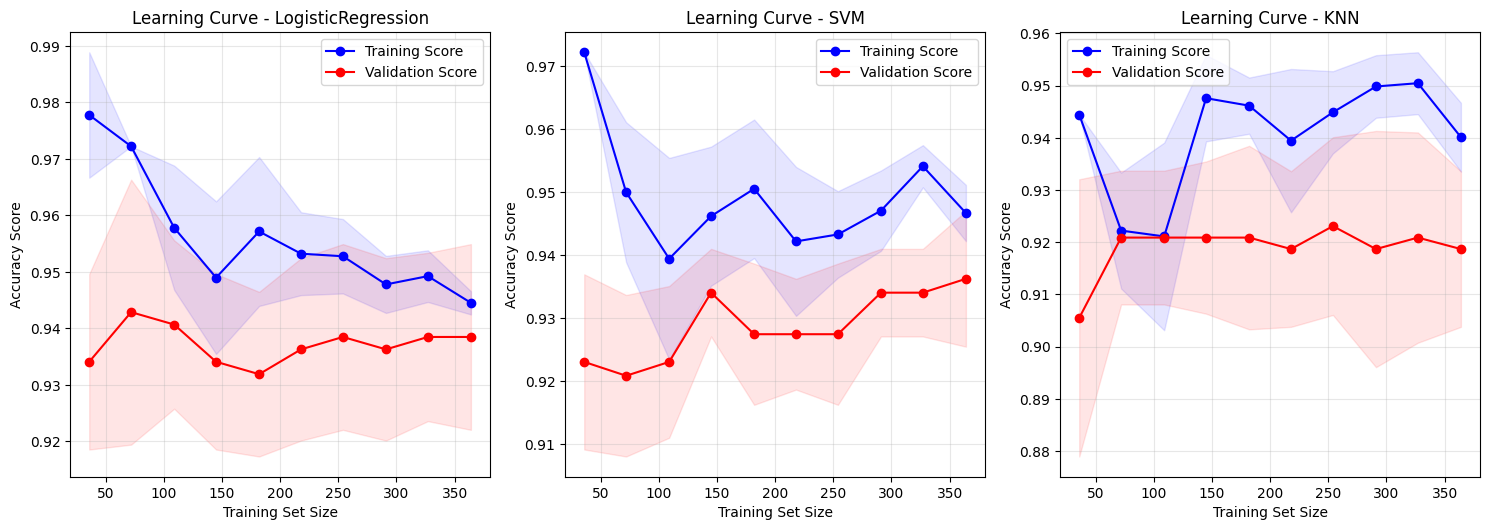

In [8]:
plot_learning_curves(models, X_train_pca, y_train)

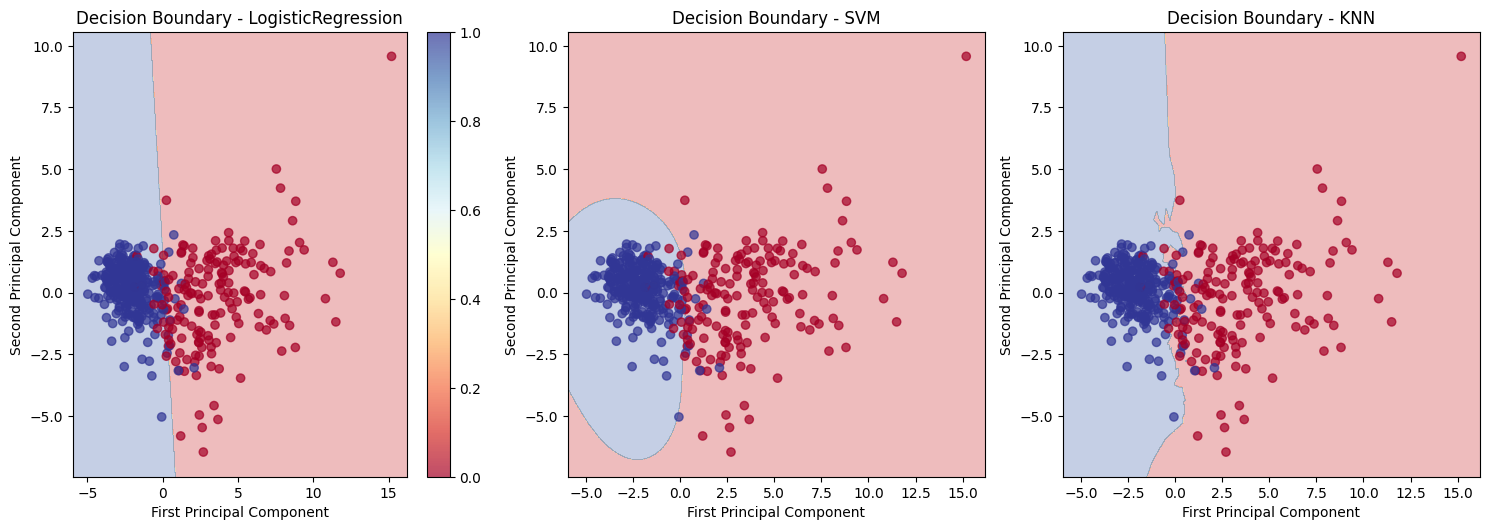

In [9]:
plot_decision_boundaries_2d(models, X_train_pca, y_train)

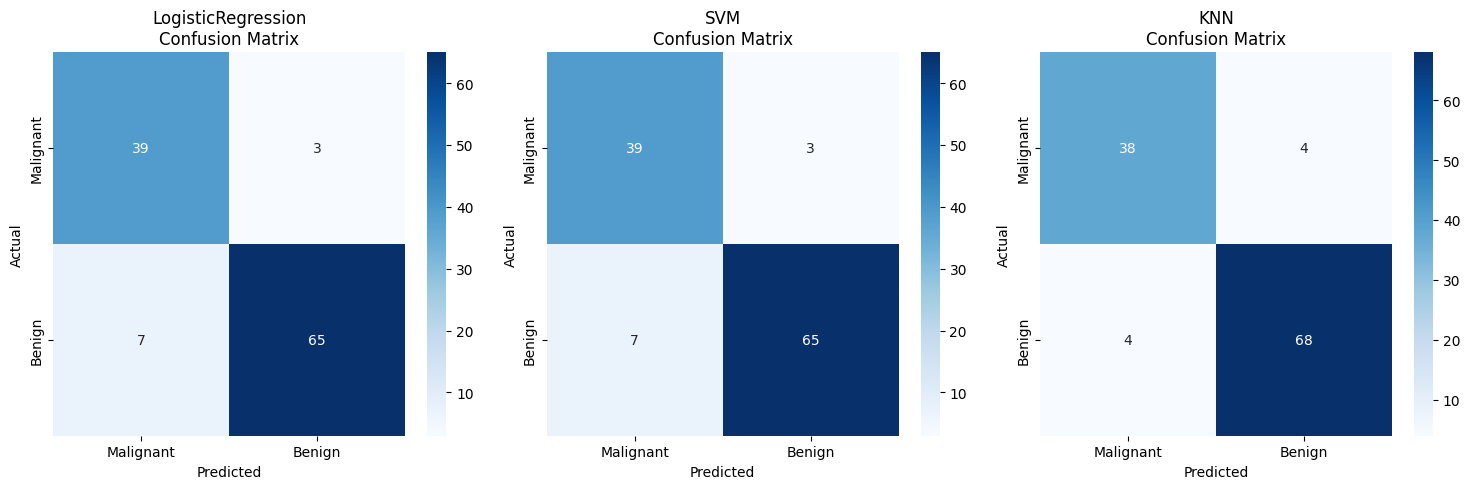

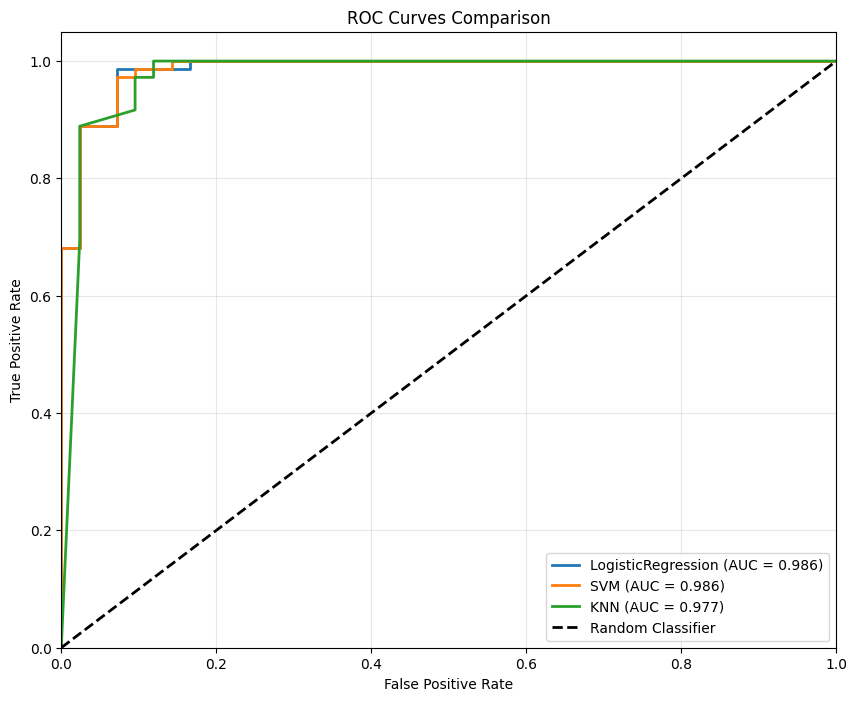

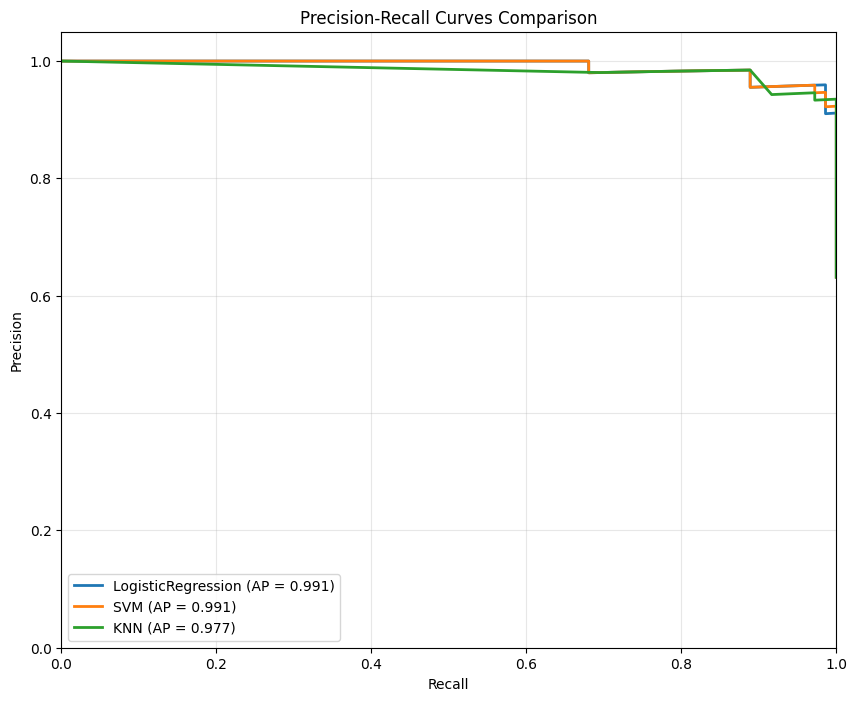

In [10]:
plot_confusion_matrices(comprehensive_results)
plot_roc_curves(comprehensive_results, y_test)
plot_precision_recall_curves(comprehensive_results, y_test)

Model Performance Comparison Table
                    accuracy  precision  recall  f1_score  specificity  false_negative_rate  false_positive_rate  positive_predictive_value  negative_predictive_value
LogisticRegression    0.9123     0.9559  0.9028    0.9286       0.9286               0.0972               0.0714                   0.955882                   0.847826
SVM                   0.9123     0.9559  0.9028    0.9286       0.9286               0.0972               0.0714                   0.955882                   0.847826
KNN                   0.9298     0.9444  0.9444    0.9444       0.9048               0.0556               0.0952                   0.944444                   0.904762


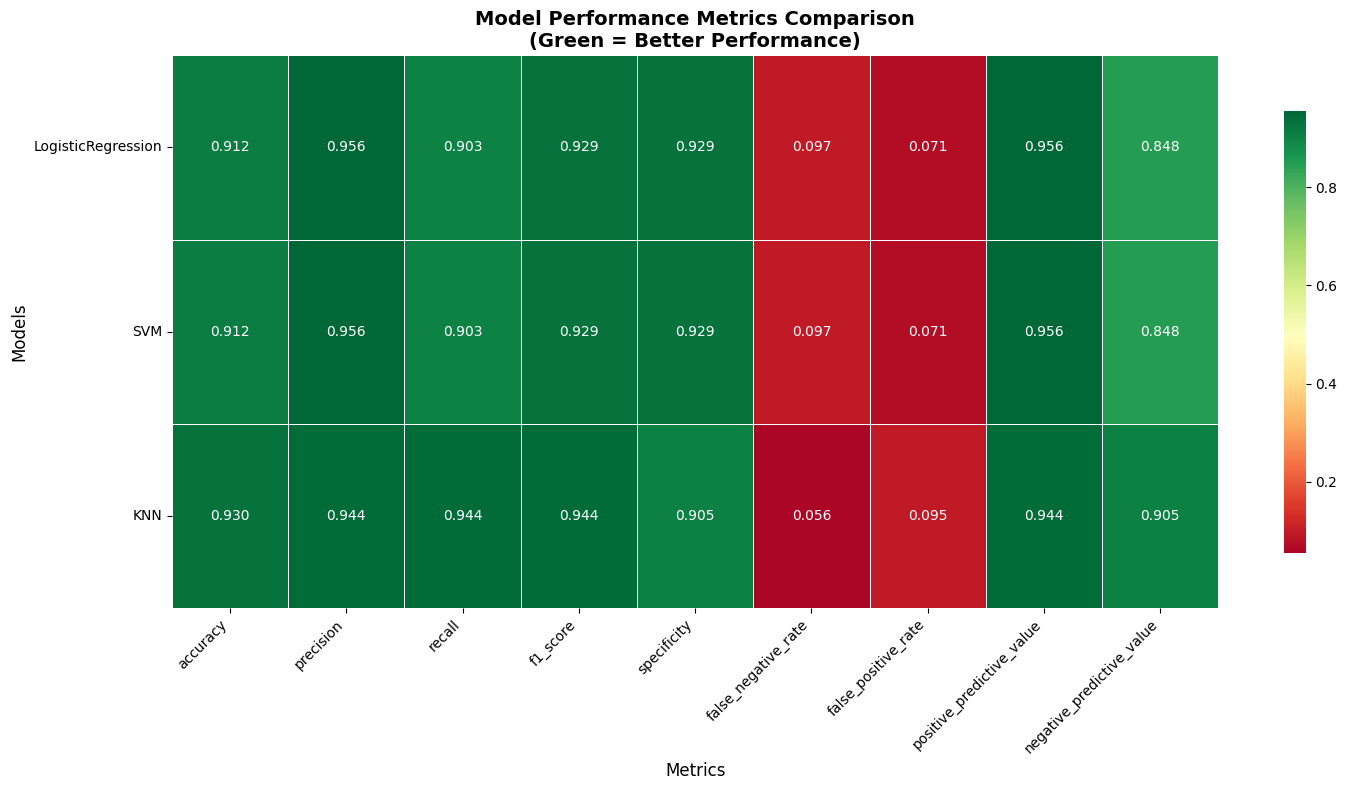


Best Performing Model per Metric:
----------------------------------------
Accuracy: KNN (0.930)
Precision: LogisticRegression (0.956)
Recall: KNN (0.944)
F1 Score: KNN (0.944)
Specificity: LogisticRegression (0.929)
False Negative Rate: KNN (0.056)
False Positive Rate: LogisticRegression (0.071)
Positive Predictive Value: LogisticRegression (0.956)
Negative Predictive Value: KNN (0.905)


In [11]:
metrics_table = plot_metrics_comparison_table(comprehensive_results)

## Results analysis

All three classifiers perform well, reaching strong, clinically usable performance (AUC ≥ 0.97): Logistic Regression and SVM tie for the highest AUC (0.986) and deliver the best precision and specificity, meaning they minimize benign‐to‐malignant false alarms; K-Nearest Neighbors achieves the top overall accuracy (0.93) and recall (0.944), yielding the fewest missed cancers at the cost of slightly more false positives. Learning curves show no severe over or under-fitting, so gains now depend on hyper-parameter tuning, feature engineering, or ensembling rather than simply adding data. Clinically, KNN is preferable if avoiding false negatives is paramount, while Logistic Regression or SVM are better when reducing unnecessary interventions and maintaining model interpretability are priorities.

We can conclude that we solved this problem with out processing.